## Download Data

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T150007Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D86b95df3c91f7fd76bd22ea599910adeaf1aaf4738b1d631e90e002173dd0cb2111794c552df7dc7e1335264ae80a2098ee8c1efe4c9d1d4e2b4a487019c41ec9de698bbf28847d87fa85d6d13e2693a1157226c52c820a0b03d2a60724a8eb3f8c0db381329042e55d5c3a8ef463fce033c63eb2165671260f69d625690a78bc7d5ab24030aeeafa061911a6f81d5e72f3bf5164d6b53af0fac91f0ebedf28e6c4cd4250fbeaf770a0b8b4ceaf3fe05b4deb8071006251af932257ed0943368d3728bc39e6f4ca8d82267348faffe1821eb28bd1e0c013151f591ba9c2c107f2ee7a1033e3a8b7bba5bb8ff6e3efba1de060c4b69624654e9e388f5f653e9aa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [2]:
%pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.6 MB/s eta 0:00:00


## Explore Data

In [50]:
import timm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import re
import pandas as pd
import random
import cv2
from PIL import Image
import transformers as T
from torchvision import transforms
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [4]:
with open("/kaggle/input/flickr8k/captions.txt", "r") as f:
    text = f.read()

In [5]:
text.split("\n")[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [6]:
data = {
    "image_path": [],
    "caption": []
}

pattern = r"^([^,]+),(.*)$"

for i, txt in enumerate(text.split("\n")[1:]):
    match_obj = re.match(pattern, txt)
    if match_obj and f"/kaggle/input/flickr8k/Images/{match_obj.group(1)}" not in data["image_path"]:
        data["image_path"].append(f"/kaggle/input/flickr8k/Images/{match_obj.group(1)}")
        data["caption"].append(match_obj.group(2))

In [7]:
df = pd.DataFrame(data=data)

In [8]:
df['image_path'].nunique(), df.shape

(8091, (8091, 2))

In [9]:
df.head()

,image_path,caption
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting
2,/kaggle/input/flickr8k/Images/1002674143_1b742...,A little girl covered in paint sits in front o...
3,/kaggle/input/flickr8k/Images/1003163366_44323...,A man lays on a bench while his dog sits by him .
4,/kaggle/input/flickr8k/Images/1007129816_e7944...,A man in an orange hat starring at something .


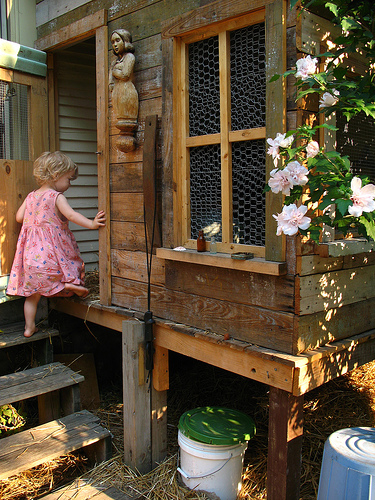

In [10]:
Image.open(df['image_path'][0])

In [11]:
tokenizer = T.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Prepare data for Training

In [12]:
def create_transforms():

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    return transform

In [13]:
class CLIPDataset(Dataset):

    def __init__(self, df: pd.DataFrame, transforms=None) -> None:

        self.df = df
        self.caption_tokenized = tokenizer(df['caption'].to_list(),
                                          padding=True,
                                          truncation=True,
                                          max_length=200)


        self.transforms = transforms
        if self.transforms is None:
            self.transforms = create_transforms()


    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:

        output = {}
        output["input_ids"] = torch.tensor(self.caption_tokenized["input_ids"][idx])
        output["attention_mask"] = torch.tensor(self.caption_tokenized["attention_mask"][idx])
        output["caption"] = self.df["caption"].iloc[idx]

        image = cv2.imread(self.df["image_path"].iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(Image.fromarray(image))

        output['image'] = image.float()

        return output



## CLIP modules

In [14]:
class ImageEncoder(nn.Module):

    def __init__(self) -> None:

        super().__init__()
        self.model = timm.create_model(model_name="resnet50",
                                      pretrained=True,
                                      num_classes=0,
                                      global_pool='avg')

    def forward(self, image: torch.Tensor) -> torch.Tensor:

        return self.model(image)

In [15]:
class TextEncoder(nn.Module):

    def __init__(self) -> None:

      super().__init__()
      self.model = T.DistilBertModel.from_pretrained("distilbert-base-uncased")

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:

      return self.model(**{"input_ids": input_ids, "attention_mask": attention_mask}).last_hidden_state[:, 0, :]


In [16]:
class ProjectionLayer(nn.Module):

  def __init__(self,
               embedding_dim: int,
               projection_dim: int) -> None:

    super().__init__()

    self.projection_layer = nn.Linear(in_features=embedding_dim,
                                      out_features=projection_dim)
    self.gelu = nn.GELU()
    self.fc = nn.Linear(in_features=projection_dim,
                        out_features=projection_dim)
    self.dropout = nn.Dropout(p=0.1)
    self.layer_norm = nn.LayerNorm(normalized_shape=projection_dim)

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    projected = self.projection_layer(x)

    x = self.dropout(self.fc(self.gelu(projected))) + projected
    x = self.layer_norm(x)

    return x

## CLIP

In [17]:
class CLIP(nn.Module):

  def __init__(self,
               image_embedding_dim: int=2048,
               text_embedding_dim: int=768,
               projection_dim: int=256) -> None:

    super().__init__()

    self.image_encoder = ImageEncoder()
    self.text_encoder = TextEncoder()
    self.image_projection = ProjectionLayer(embedding_dim=image_embedding_dim,
                                            projection_dim=projection_dim)
    self.text_projection = ProjectionLayer(embedding_dim=text_embedding_dim,
                                           projection_dim=projection_dim)


  def forward(self, image: torch.Tensor, token: torch.Tensor, attention_mask: torch.Tensor) -> Tuple[torch.Tensor]:

    image_embedding = self.image_encoder(image) # B, image_embedding_dim
    text_embedding = self.text_encoder(token, attention_mask) # B, text_embedding_dim

    projected_image_embedding = self.image_projection(image_embedding) # B, projection_dim
    projected_text_embedding = self.text_projection(text_embedding) # B, projection_dim

    text_logits = projected_text_embedding @ projected_text_embedding.T # B, B
    image_logits = projected_image_embedding @ projected_image_embedding.T # B, B
    targets = F.softmax((text_logits+image_logits)/2, dim=-1)

    logits = projected_image_embedding @ projected_text_embedding.T # B, B
    image_loss = self._cross_entropy(logits, targets, reduction="none")
    text_loss = self._cross_entropy(logits.T, targets.T, reduction="none")
    loss = (image_loss+text_loss)/2
    return logits, loss.mean()


  def _cross_entropy(self, logits: torch.Tensor, targets: torch.Tensor, reduction: str="none") -> torch.Tensor:

    log_softmax = nn.LogSoftmax()
    loss = -targets*log_softmax(logits) # B, B
    return loss if reduction=="none" else loss.mean()

## Train

In [18]:
def create_train_test_dl(df: pd.DataFrame, test_size: float=0.2) -> Tuple[DataLoader]:

  ids = list(range(df.shape[0]))
  test_ids = random.sample(ids, k=int(df.shape[0]*test_size))
  train_ids = [i for i in ids if i not in test_ids]

  train_df = df.iloc[train_ids, :].copy(deep=True)
  test_df = df.iloc[test_ids, :].copy(deep=True)

  train_df = train_df.reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)

  train_ds, test_ds = CLIPDataset(df=train_df), CLIPDataset(df=test_df)
  train_dl = DataLoader(dataset=train_ds,
                        batch_size=16,
                        shuffle=True)
  test_dl = DataLoader(dataset=test_ds,
                       batch_size=16,
                       shuffle=False)
  return train_dl, test_dl

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dl, test_dl = create_train_test_dl(df=df)

In [20]:
clip = CLIP().to(device)

optimizer = torch.optim.AdamW(params=clip.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [21]:
def train_step() -> float:

  clip.train()
  total_loss = 0

  for batch in train_dl:
    image, token, attention_mask = batch['image'], batch['input_ids'], batch['attention_mask']
    image, token, attention_mask = image.to(device), token.to(device), attention_mask.to(device)

    _, loss = clip(image, token, attention_mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(train_dl)

@torch.inference_mode()
def eval_step() -> float:

  clip.eval()
  total_loss = 0

  for batch in test_dl:

    image, token, attention_mask = batch['image'], batch['input_ids'], batch['attention_mask']
    image, token, attention_mask = image.to(device), token.to(device), attention_mask.to(device)

    _, loss = clip(image, token, attention_mask)

    total_loss += loss.item()

  return total_loss/len(test_dl)

In [22]:
def main(epochs: int=2):

  for epoch in range(1, epochs+1):
    train_loss = train_step()
    test_loss = eval_step()

    print(f"({epoch}/{epochs}) train: {train_loss:.4f} test: {test_loss:.4f}")

In [23]:
main(2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(1/2) train: 0.2399 test: 0.1170
(2/2) train: 0.0919 test: 0.0762


## Inference

In [24]:
## create embeddings

@torch.inference_mode()
def create_image_embeddings(df: pd.DataFrame) -> torch.Tensor:

  clip.eval()

  ds = CLIPDataset(df=df)
  dl = DataLoader(dataset=ds, batch_size=64, shuffle=False)

  image_embeddings = []
  for batch in dl:
    image = batch['image']
    image = image.to(device)

    embeddings = clip.image_projection(clip.image_encoder(image)) # B, projection_dim
    image_embeddings.append(embeddings)

  return torch.cat(image_embeddings, dim=0)

In [25]:
image_embeddings = create_image_embeddings(df=df)

In [26]:
image_embeddings.shape

torch.Size([8091, 256])

In [63]:
@torch.inference_mode()
def inference(query: str, df: pd.DataFrame, n_top_images: int=5):

  query_tokenized = tokenizer([query], padding=True, truncation=True, max_length=200)

  tokens, attention_mask = query_tokenized['input_ids'], query_tokenized['attention_mask']
  tokens, attention_mask = torch.tensor(tokens).to(device), torch.tensor(attention_mask).to(device)

  query_embedding = clip.text_projection(clip.text_encoder(tokens, attention_mask)) # 1, projection_dim

  logits = image_embeddings @ query_embedding.T # No of images, 1
  top_n_indices = torch.topk(logits.squeeze(), n_top_images).indices.tolist()
  top_image_paths = df.iloc[top_n_indices]['image_path'].to_list()
  top_image_captions = df.iloc[top_n_indices]['caption'].to_list()

  fig, axes = plt.subplots(nrows=3, ncols=math.ceil(n_top_images//3), figsize=(20, 8))
  for ax, img_path, caption in zip(axes.flatten(), top_image_paths, top_image_captions):
      img = Image.open(img_path)
      img = img.resize((300, 300))
      img = mpimg.pil_to_array(img)
      ax.imshow(img)
      # ax.set_title(caption)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

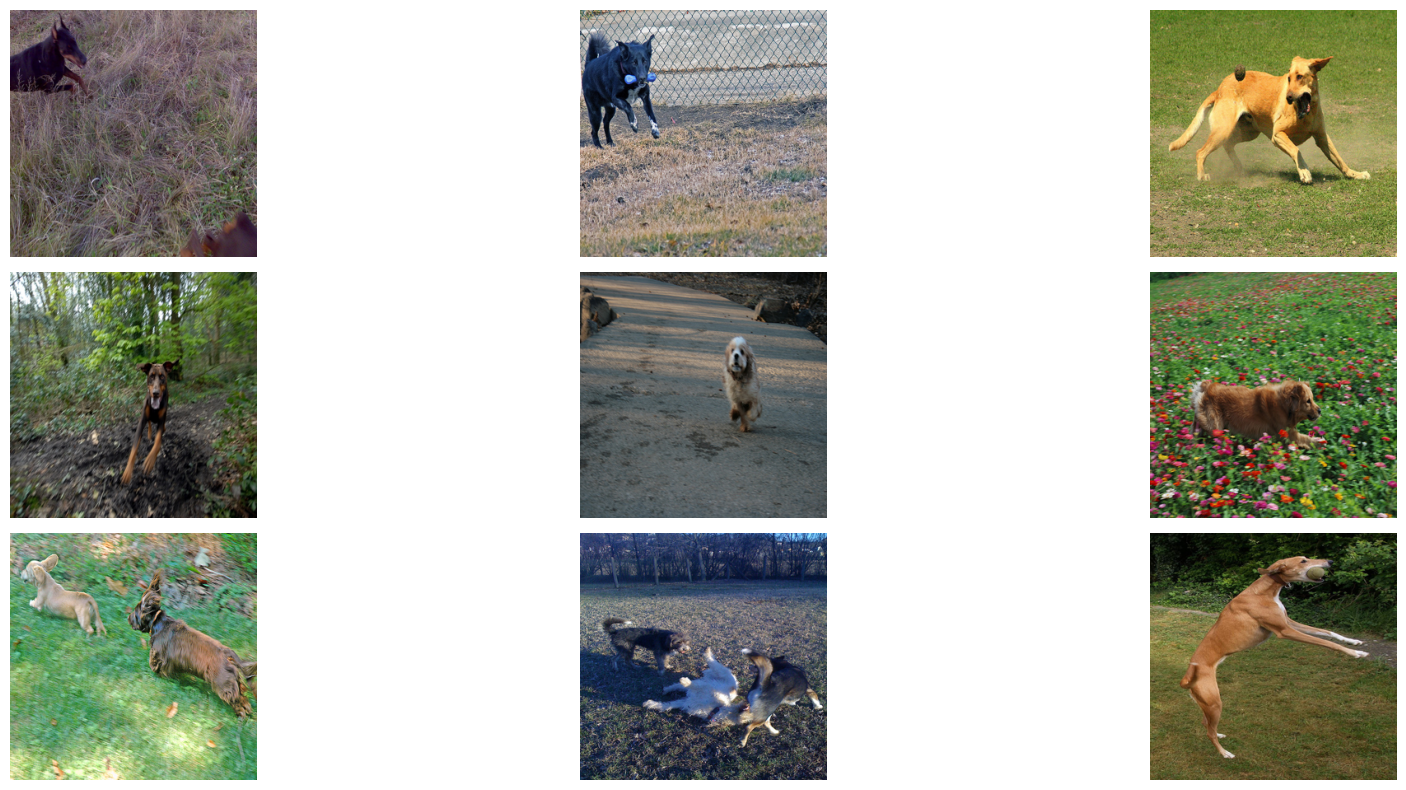

In [65]:
inference(query="dog running in a ground", df=df, n_top_images=9)